# PyTorch Workflow

Let's explore an example PyTorch end-to-end workflow

In [9]:
what_we_are_covering = {1: "data (prepare and load)",
                        2: "build model",
                        3: "fitting the model to data (training)",
                        4: "making predictions and evaluating the model",
                        5: "saving and loading a model",
                        6: "putting it all together"}

In [10]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt
import numpy as np

# Check PyTorch version
torch.__version__

'2.3.1'

## 1. Data (preparing and loading)

Data can be almost anything... in machine learning.

* Excel spreadsheet
* Images of any kind
* Videos (YouTube has lots of data)
* Audios like songs or podcasts
* DNA
* Text

Machine learning is a game of two parts:
1. Get data into a numerical representation.
2. Build a model to learn patterns in that numerical representation.

To showcase this, let's create some *known* data using the linear regression formula.

We'll use a linear regression formula to make a straight line with *known* **parameters**

In [11]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:5], y[:5]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560]]))

### Splitting data into training and test sets (one of the most important concepts in machine learning in general)

Let's create a training and test set with our data

In [12]:
# Create a train/test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

How might we better visualize our data?

This is where the data explorer's motto comes in!

"Visualize, visualize, visualize!"

In [13]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
    plt.figure(figsize=(10, 7))

    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        plt.scatter(test_data, predictions, c='r', s=4, label="Predictions")

    plt.legend(prop={"size": 14})

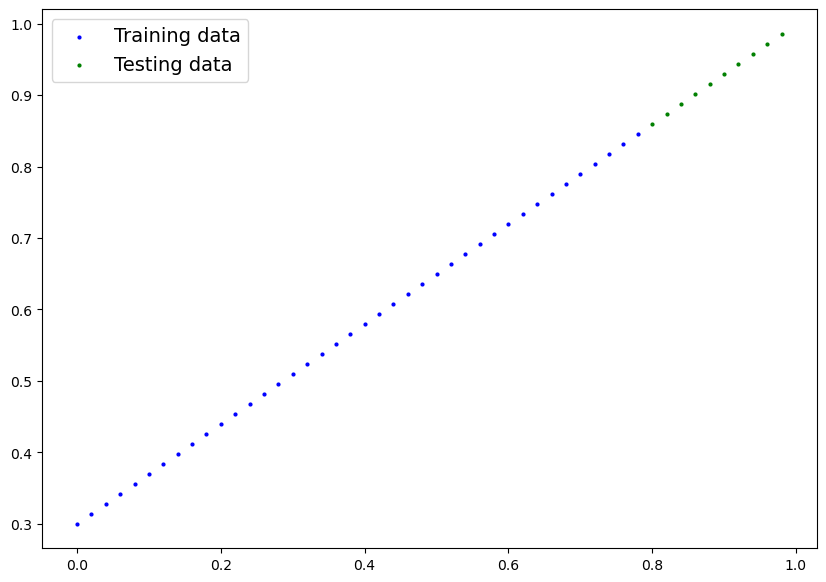

In [14]:
plot_predictions()

## 2. Build model

Our first PyTorch model!

What our model does:
* Start with random values (weight and bias)
* Look at training data and adjust the random values to better represent (or get closer to) the ideal values (the weight & bias values we used to create the data)

How does it do so?

Through two main algorithms:
1. Gradient descent
2. Backpropogation

In [15]:
# Create linear regression model class
class LinearRegressionModel(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1,
                                                requires_grad=True,
                                                dtype=torch.float))
        
        self.bias = nn.Parameter(torch.randn(1,
                                             requires_grad=True,
                                             dtype=torch.float))
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias

### PyTorch model building essentials

* torch.nn - contains all of the building blocks for computational graphs (a neural netwrok can be considered as a computational graph).
* torch.nn.Parameter - what parameters should our model try and learn, often a PyTorch layer from torch.nn will set these for us.
* torch.nn.Module - The base class for all neural network modules, if you subclass it, you should overwrite forward().
* torch.optim - This is where the optimizers in PyTorh live, they will help with gradient descent.
* def forward() - All nn.Module subclasses requires you to overwrite forward(), this method defines what happens in the foward computation

See more of these essential modules via the PyTorch cheatsheet: https://pytorch.org/tutorials/beginner/ptcheat.html

### Checking the contents of our PyTorch model

Now we've created a model, let's see what's inside...

So we can check our model paramenters or what's inside our model using '.parameters()'

In [16]:
# Create a random seed
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module)
model_0 = LinearRegressionModel()

# Check out the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [17]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making prediction using 'torch.inference_mode()'

To check our model's predictive power, let's see how well it predicts y_test based on X_test

When we pass data through our model, it's going to run it through the forward() method.

In [18]:
# Make predictions with model
with torch.inference_mode():
    y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

In [19]:
y_test

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

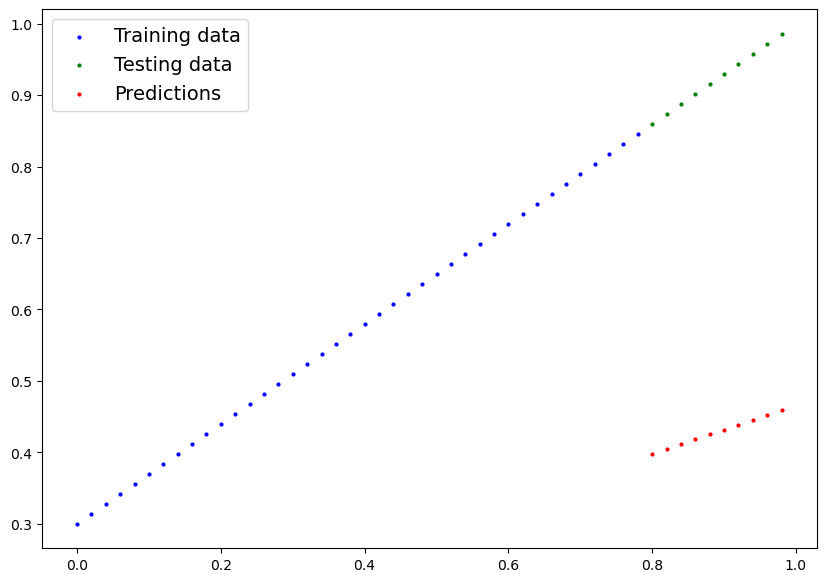

In [20]:
plot_predictions(predictions=y_preds)

 # 3. Train model

The whole idea of training is for a model to move from some *unknown* parameters (these may be random) to some *known* parameters.PendingDeprecationWarning

Or in other words from a poor representation of the data to a better representation of the data.

One way to measure how poor or how wrong your models predictions are is to use a loss function.

* Note: Loss function may also be called cost function or criterion in different areas. For our case, we're going to refer to it as a loss function.

Things we need to train:

* **Loss function**: A funciton to measure how wrong your mode's predictions are to the ideal outputs, lower is better.
* **Optimizer**: Takes into account the loss of a model and adjusts the model's parameters (e.g. weight & bias in our case to improve the loss function).

And specifically for PyTorch, we need:
* A training loop
* A testing loop

In [21]:
# Checkout out our model's parameters (a parameter is a value that the model sets itself)
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [22]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), 
                            lr= 0.01 # lr = learning rate = possibly the most important hyperparameter that you can set
                        )

**Q:** Which loss funciton and optimizer should I use?
**A:** This will be problem specific. But with experience, you'll get an idea of what works and what doesn't with your particular problem set.

For example, for regression problem (like ours), a loss function of `nn.L1Loss()` and an optimizer like `torch.optim.SGD()` will suffice.

But for classification problem like classifying whether a photo is of a dog or a cat, you'll likely want to use a loss function of `nn.BCELoss()` (binary cross entropy loss).

### Building a training loop (and a testing loop) in PyTorch

A couple of things we need in a training loop:

0. Loop through the data and do...
1. Forward pass (this involves data moving through our model's `forward()` functions) to make predictions on data - also called forward propagation
2. Calculate the loss (compare forward pass predictions to ground truth labels)
3. Optimizer zero grad
4. Loss backward - move backwards through the network to calculate the gradients of each of the parameters of our model with respect to the loss (**backpropagation**)
5. Optimizer step - use the optimizer to adjust our model's parameters to try and improve the loss (**gradient descent**)


In [23]:
torch.manual_seed(42)
# An epoch is one loop through the data... (this is a hyperparameter because we've set it ourselves)
epochs = 140

# Track different values
epoch_count = []
loss_values = []
test_loss_values = []

## Training 
# 0. Loop through the data
for epoch in range(epochs):
    # Set the model to training mode
    model_0.train() # train mode in PyTorch sets all parameters that require gradients to require gradients

    # 1. Forward pass
    y_pred = model_0(X_train)

    # 2. Calculate the loss
    loss = loss_fn(y_pred, y_train)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Perform back propogation on the loss with respect to the parameters of the model
    loss.backward()

    # 5. Step the optimizer (perform gradient descent)
    optimizer.step() # by default how the optimizer changes will accumulate through the loop so... we have to zero them above in step 3 for the next iteration of the loop

    ### Testing
    model_0.eval() # turns off different settings in the model not needed for evaluation/testing (dropout/batch)
    with torch.inference_mode(): # turns off gradient tracking & a couple more things behind the scenes
        # 1. Do the forward pass
        test_pred = model_0(X_test)

        # 2. Calculate the loss
        test_loss = loss_fn(test_pred, y_test)

    # Print out what's happening
    if epoch % 10 == 0:
        epoch_count.append(epoch)
        loss_values.append(loss)
        test_loss_values.append(test_loss)
        print(f'Epoch: {epoch} | LOSS: {loss} | Test loss: {test_loss}')


Epoch: 0 | LOSS: 0.31288138031959534 | Test loss: 0.48106518387794495
Epoch: 10 | LOSS: 0.1976713240146637 | Test loss: 0.3463551998138428
Epoch: 20 | LOSS: 0.08908725529909134 | Test loss: 0.21729660034179688
Epoch: 30 | LOSS: 0.053148526698350906 | Test loss: 0.14464017748832703
Epoch: 40 | LOSS: 0.04543796554207802 | Test loss: 0.11360953003168106
Epoch: 50 | LOSS: 0.04167863354086876 | Test loss: 0.09919948130846024
Epoch: 60 | LOSS: 0.03818932920694351 | Test loss: 0.08886633068323135
Epoch: 70 | LOSS: 0.03476089984178543 | Test loss: 0.0805937647819519
Epoch: 80 | LOSS: 0.03132382780313492 | Test loss: 0.07232122868299484
Epoch: 90 | LOSS: 0.02788740023970604 | Test loss: 0.06473556160926819
Epoch: 100 | LOSS: 0.024458957836031914 | Test loss: 0.05646304413676262
Epoch: 110 | LOSS: 0.021020209416747093 | Test loss: 0.04819049686193466
Epoch: 120 | LOSS: 0.01758546754717827 | Test loss: 0.04060482233762741
Epoch: 130 | LOSS: 0.014155392535030842 | Test loss: 0.03233227878808975


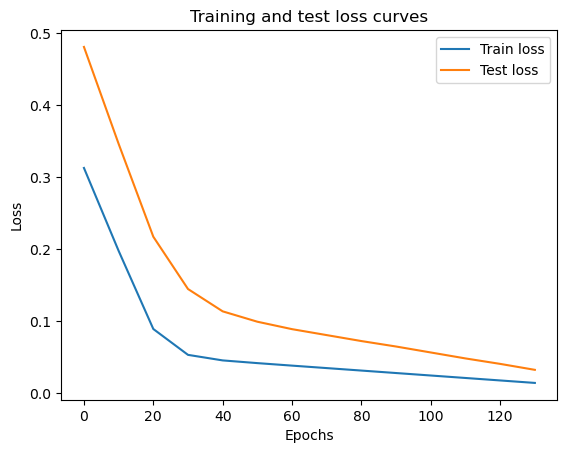

In [24]:
# Plot the loss curves
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label="Train loss")
plt.plot(epoch_count, np.array(torch.tensor(test_loss_values).numpy()), label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

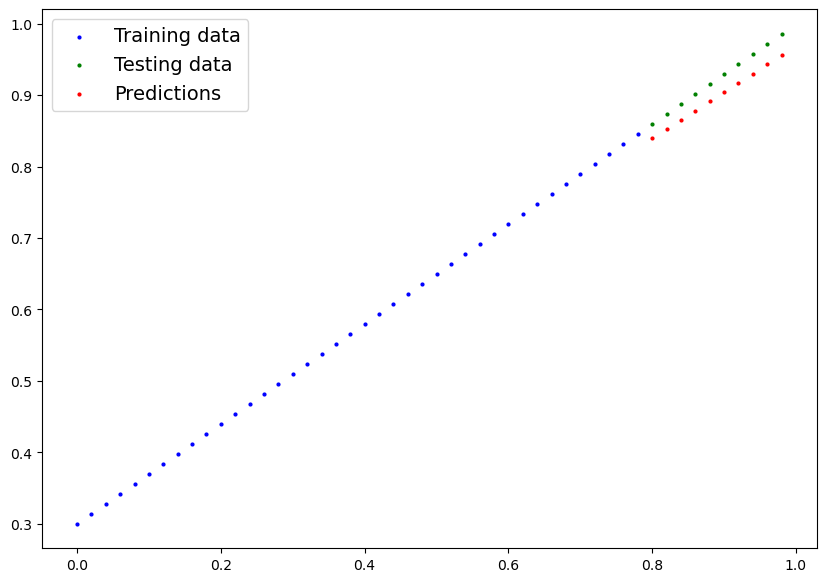

In [25]:
with torch.inference_mode():
    y_preds_new = model_0(X_test)

plot_predictions(predictions=y_preds_new)

## Saving/Loading a model in PyTorch

There are three main methods we should know about for saving and loading models in PyTorch

1. `torch.save()` - allows you save a PyTorch object in Python's pickle format
2. `torch.load()` - allos you load a svaed PyTorch object
3. `torch.nn.Module.load_state_dict()` - this allows to load a model's saved state dictionary

In [26]:
# Saving the PyTorch model
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path('../models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: ../models/01_pytorch_workflow_model_0.pth


## Loading the PyTorch model

Since we saved our model's `state_dict()` rather the entire model, we'll create a new instance of our model class and load the saved `state_dict()` into that.

In [27]:
# To load in a saved state_dict we have to instantiate a new instance of our model class
loaded_model_0 = LinearRegressionModel()

# Load the saved state_dict of model_0 (this will update the new instance with updated paramters)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [28]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6467])), ('bias', tensor([0.3223]))])

In [29]:
# Make some predictions with our loaded model
loaded_model_0.eval()
with torch.inference_mode():
    y_preds = loaded_model_0(X_test)

y_preds

tensor([[0.8396],
        [0.8526],
        [0.8655],
        [0.8784],
        [0.8914],
        [0.9043],
        [0.9172],
        [0.9302],
        [0.9431],
        [0.9560]])

## 6. Putting it all together

Let's go back through the steps above and see it all in one place

In [30]:
# Import PyTorch and matplotlib
import torch 
from torch import nn
import matplotlib.pyplot as plt

# Check version
torch.__version__

'2.3.1'

Create device-agnostic code
If there's a GPU our code will use it. If not code is default set to use CPU

In [31]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


### 6.1 Data

In [53]:
# Create data using linear regression formula y = mx + c
weight = 0.7
bias = 0.3

# Create range values
start = 0
end = 1
step = 0.02

# Create X and y (features and labels)
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [54]:
# Split data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

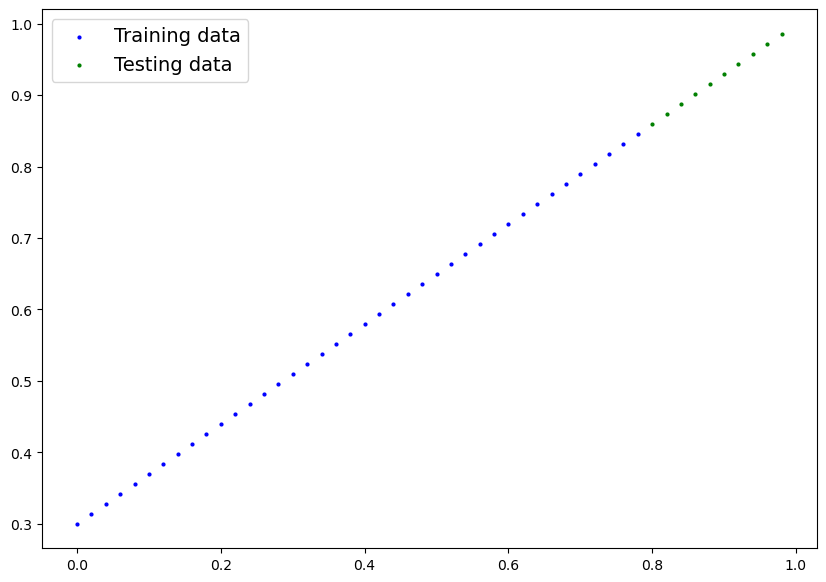

In [55]:
# Let's plot predictions
plot_predictions(X_train, y_train, X_test, y_test)

### 6.2 Building a PyTorch Linear Model

In [56]:
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer = nn.Linear(in_features=1,
                                      out_features=1)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)
    
# Set manual seed
torch.manual_seed(21)

model_1 = LinearRegressionModelV2()
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[-0.0529]])),
             ('linear_layer.bias', tensor([0.2272]))])

### 6.3 Training

For training we need:
- Loss function
- Optimizer
- Training Loop
- Testing Loop

In [57]:
# Setup loss function
loss_fn = nn.L1Loss()
loss_fn

# Setup optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), 
                            lr=0.01)

In [58]:
torch.manual_seed(21)

epochs = 200

for epoch in range(epochs):
    model_1.train()

    y_pred = model_1(X_train)

    loss = loss_fn(y_pred, y_train)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    ### Testing loop
    model_1.eval()
    with torch.inference_mode():
        test_pred = model_1(X_test)

        test_loss = loss_fn(test_pred, y_test)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss} | Test Loss: {test_loss}")

Epoch: 0 | Loss: 0.3664190471172333 | Test Loss: 0.7293795347213745
Epoch: 10 | Loss: 0.254568874835968 | Test Loss: 0.5971873998641968
Epoch: 20 | Loss: 0.18397650122642517 | Test Loss: 0.4911789000034332
Epoch: 30 | Loss: 0.14738419651985168 | Test Loss: 0.4129011034965515
Epoch: 40 | Loss: 0.12870903313159943 | Test Loss: 0.3569414019584656
Epoch: 50 | Loss: 0.11864493042230606 | Test Loss: 0.31741708517074585
Epoch: 60 | Loss: 0.11269068717956543 | Test Loss: 0.28962504863739014
Epoch: 70 | Loss: 0.1082306057214737 | Test Loss: 0.2691485583782196
Epoch: 80 | Loss: 0.10436441749334335 | Test Loss: 0.2533825933933258
Epoch: 90 | Loss: 0.10087442398071289 | Test Loss: 0.24236278235912323
Epoch: 100 | Loss: 0.09738440066576004 | Test Loss: 0.23134300112724304
Epoch: 110 | Loss: 0.09389439970254898 | Test Loss: 0.2203228920698166
Epoch: 120 | Loss: 0.09042999893426895 | Test Loss: 0.2106766253709793
Epoch: 130 | Loss: 0.08699119091033936 | Test Loss: 0.20240406692028046
Epoch: 140 | Los

### 6.4 Making Predictions

In [59]:
# Turn model into evaluation mode
model_1.eval()

# Make predictions on the test data
with torch.inference_mode():
    y_preds = model_1(X_test)

y_preds

tensor([[0.7412],
        [0.7489],
        [0.7567],
        [0.7644],
        [0.7722],
        [0.7799],
        [0.7876],
        [0.7954],
        [0.8031],
        [0.8108]])

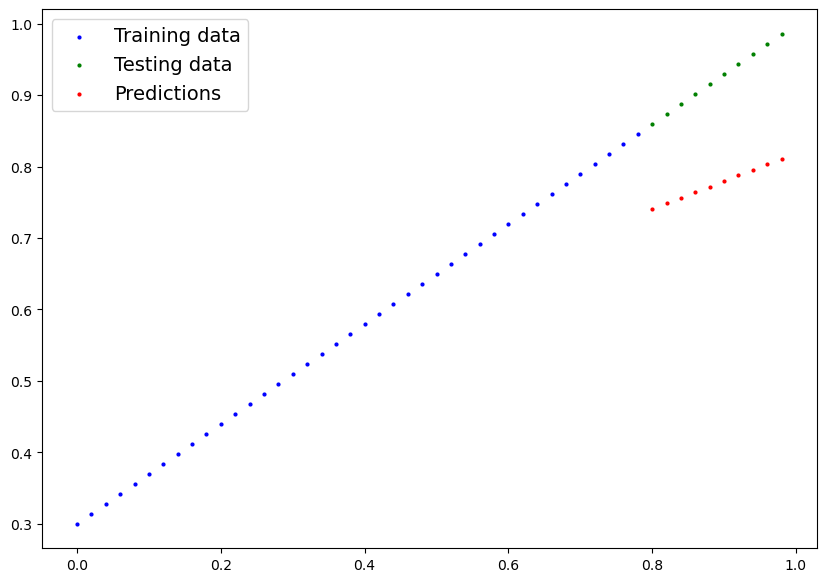

In [60]:
plot_predictions(predictions=y_preds)